In [1]:
from SimPEG.Utils import speye, kron3, sdiag, mkvc
from SimPEG import Mesh, Utils, Maps, PF, Regularization, Optimization, Directives, DataMisfit, InvProblem, Inversion
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt




In [12]:
from SimPEG import Utils
# Create block problem for gravity ... nothing new here you can skip to the next cell
# Magnetic inducing field parameter (A,I,D)


# Create a mesh
dx = 5.
npad = 0
hxind = [(dx, npad, -1.3), (dx, 50), (dx, npad, 1.3)]
hyind = [(dx, npad, -1.3), (dx, 50), (dx, npad, 1.3)]
hzind = [(dx, npad, -1.3), (dx, 30)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
mesh.x0[2] -= mesh.vectorNz[-1]

susc = 0.2
nX = 3

# Get index of the center of block
locx = [int(mesh.nCx/2)]#[int(mesh.nCx/2)-3, int(mesh.nCx/2)+3]
midy = int(mesh.nCy/2)
midz = -10

# Create and array of observation points
xr = np.linspace(-100, 100., 7)
yr = np.linspace(-100, 100., 7)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.ones_like(X) * mesh.vectorNz[-1] + dx

# Create a MAGsurvey
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseGrav.RxObs(xyzLoc)
srcField = PF.BaseGrav.SrcField([rxLoc])
survey = PF.BaseGrav.LinearSurvey(srcField)

# We can now create a susceptibility model and generate data
# Here a simple block in half-space
model = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))
for midx in locx:
    model[(midx-nX):(midx+nX+1), (midy-nX):(midy+nX+1), (midz-nX):(midz+nX+1)] = susc
model = Utils.mkvc(model)

actv = np.ones(mesh.nC, dtype='bool')

Begin calculation of forward operator: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



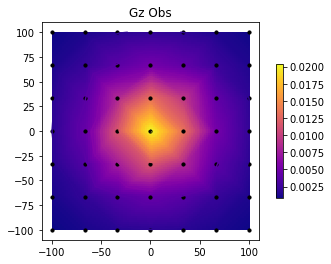

Observation file saved to: RotatedCube.obs


In [41]:
# Generate data
idenMap = Maps.IdentityMap(nP=mesh.nC)
prob = PF.Gravity.GravityIntegral(mesh, rhoMap = idenMap)
survey.pair(prob)

data = prob.fields(model)

survey.dobs = data
survey.std = np.ones(survey.nD)*1e-4
xyzLoc = survey.srcField.rxList[0].locs
ax = PF.Gravity.plot_obs_2D(xyzLoc,d=data)
plt.show()

Mesh.TensorMesh.writeUBC(mesh,'Mesh.msh')
Mesh.TensorMesh.writeModelUBC(mesh,'RotatedCube.den',model)
PF.Gravity.writeUBCobs('RotatedCube.obs',survey, data)

In [55]:
"""
TO LINDSEY:

This is the stuff I would like to get in the framework.
The getDiffOpRot function can probably be splitted in many sub-functions/properties
The strategy is:
    1- Rotate the x, y or z vectors (the usual forward or backward difference directions)
        along a different orientation specified by three angles (psi, theta, phi). 
        psi : Rotation around the x-axis 
        theta: Rotation around the y-axis 
        phi : Rotation around z-axis 
        
    2- Move the center of a unit block with the same orientation
    
    3- Calculate the partial volumes intersected with the unit block with the 26 blocks
        making a 3-by-3-by-3 stencil
    
    4- Construct a new forward or backward difference operator by summing up the contribution of 
        all non-zero operators of the 26-point stencil (+1 for the center block)
        
    5- Repeat for all three x, y and z gradient operators

    I created a little GUI at the bottom of the notebook for us to see what the gradients look like
    for different components and angles.
    
""" 


def ddx(n,vals):
    """Define 1D averaging operator from cell-centers to nodes."""
    ddx = (
        sp.sparse.spdiags(
            (np.ones((n, 1)) * vals).T,
            [-1, 0, 1],
            n , n,
            format="csr"
        ) 
    )
    return ddx


def getDiffOpRot(mesh, psi, theta, phi, vec, forward = True):
    
    unitMesh = Mesh.TensorMesh([np.ones(3),np.ones(3),np.ones(3)], x0='CCC')
    
    stencil = []
    for ii in range(unitMesh.nC):
        stencil += [np.kron(np.r_[-1,1],[0.5,0.5,0.5]).reshape((2,3)) + np.kron(np.ones(2),unitMesh.gridCC[ii,:]).reshape((2,3))]

    if isinstance(theta, float):
        theta = np.ones(mesh.nC) * theta
    if isinstance(phi, float):
        phi = np.ones(mesh.nC) * phi
    if isinstance(psi, float):
        psi = np.ones(mesh.nC) * psi

    if forward:
        ind = 1
    else:
        ind = -1
        
    if vec=='X':
        px = np.kron(np.ones(mesh.nC),np.c_[ind,0,0])
    elif vec=='Y':
        px = np.kron(np.ones(mesh.nC),np.c_[0,ind,0])
    else:
        px = np.kron(np.ones(mesh.nC),np.c_[0,0,ind])  

    #     v = np.ones((mesh.nC,27))
    #     for ii in range(mesh.nC):

    # Create sparse rotation operators
    rxa = mkvc(np.c_[np.ones(mesh.nC), np.cos(psi), np.cos(psi)].T)
    rxb = mkvc(np.c_[np.zeros(mesh.nC), np.sin(psi),np.zeros(mesh.nC)].T)
    rxc = mkvc(np.c_[np.zeros(mesh.nC), -np.sin(psi),np.zeros(mesh.nC)].T)
    Rx = sp.sparse.diags([rxb[:-1],rxa,rxc[:-1]],[-1,0,1])

    rya = mkvc(np.c_[np.cos(theta), np.ones(mesh.nC), np.cos(theta)].T)
    ryb = mkvc(np.c_[-np.sin(theta), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
    ryc = mkvc(np.c_[np.sin(theta), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
    Ry = sp.sparse.diags([ryb[:-2],rya,ryc[:-2]],[-2,0,2])

    rza = mkvc(np.c_[np.cos(phi), np.cos(phi),np.ones(mesh.nC)].T)
    rzb = mkvc(np.c_[np.sin(phi), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
    rzc = mkvc(np.c_[-np.sin(phi), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
    Rz = sp.sparse.diags([rzb[:-1],rza,rzc[:-1]],[-1,0,1])

    # Rotate all cell vectors
    rx = (Rz*(Ry*(Rx*px.T))).reshape((mesh.nC,3))

    # Move the bottom-SW and top-NE nodes
    nBSW = np.kron(stencil[13][0],np.ones((mesh.nC,1)))+rx
    nTNE = np.kron(stencil[13][1],np.ones((mesh.nC,1)))+rx

    # Compute fractional volumes with base stencil
    V=[]
    for s in stencil:

        sBSW = np.kron(s[0],np.ones((mesh.nC,1)))
        sTNE = np.kron(s[1],np.ones((mesh.nC,1)))

        V += [(np.max([np.min([sTNE[:, 0], nTNE[:, 0]])-np.max([sBSW[:, 0], nBSW[:, 0]]), 0]) *
         np.max([np.min([sTNE[:, 1], nTNE[:, 1]])-np.max([sBSW[:, 1], nBSW[:, 1]]), 0]) * 
         np.max([np.min([sTNE[:, 2], nTNE[:, 2]])-np.max([sBSW[:, 2], nBSW[:, 2]]), 0]))]

    count = -1
    Gx = speye(mesh.nC)

    for ii in range(3):
        flagz = [0,0,0]
        flagz[ii] = 1

        for jj in range(3):
            flagy = [0,0,0]
            flagy[jj] = 1

            for kk in range(3):

                flagx = [0,0,0]
                flagx[kk] = 1

                count += 1
                Gx -= sdiag(np.ones(mesh.nC)*V[count])*kron3( ddx(mesh.nCz,flagz), ddx(mesh.nCy,flagy), ddx(mesh.nCx,flagx) )

    return Gx




In [106]:
theta = np.ones(mesh.nC)*np.deg2rad(0.)
phi = np.ones(mesh.nC)*np.deg2rad(0.)


indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.G.shape[1])
for ii in range(survey.nD):
    wr += (prob.G[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg1.norms = [0, 0.5, 0.5, 0.5]
reg1.eps_p = 2e-3
reg1.eps_q = 5e-4
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg2.norms = [0, 0.5, 0.5, 0.5]
reg2.eps_p = 2e-3
reg2.eps_q = 5e-4
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3, maxIRLSiter=10)
update_Jacobi = Directives.Update_lin_PreCond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec90 = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.97e+08  7.63e+04  3.15e-06  7.69e+04    2.74e+02      0              
   1  9.85e+07  7.25e+04  1.24e-05  7.37e+04    2.74e+02      0              
   2  4.93e+07  6.89e+04  3.96e-05  7.08e+04    2.74e+02      0   Skip BFGS  
   3  2.46e+07  6.28e+04  1.32e-04  6.60e+04    2.74e+02      0   Skip BFGS  
   4  1.23e+07  5.35e+04  4.08e-04  5.85e+04    2.74e+02      0   Skip BFGS  
   5  6.16e+06  4

In [116]:

theta = np.ones(mesh.nC)*np.deg2rad(0.)
phi = np.ones(mesh.nC)*np.deg2rad(30.)


indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.G.shape[1])
for ii in range(survey.nD):
    wr += (prob.G[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg1.norms = [0, 0.5, 0.5, 0.5]
reg1.eps_p = 2e-3
reg1.eps_q = 5e-4
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg2.norms = [0, 0.5, 0.5, 0.5]
reg2.eps_p = 2e-3
reg2.eps_q = 5e-4
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3, maxIRLSiter=10)
update_Jacobi = Directives.Update_lin_PreCond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec30 = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.29e+08  7.63e+04  3.15e-06  7.70e+04    2.74e+02      0              
   1  1.15e+08  7.30e+04  9.82e-06  7.42e+04    2.74e+02      0              
   2  5.74e+07  6.99e+04  3.04e-05  7.16e+04    2.74e+02      0   Skip BFGS  
   3  2.87e+07  6.44e+04  1.02e-04  6.73e+04    2.74e+02      0   Skip BFGS  
   4  1.43e+07  5.58e+04  3.22e-04  6.04e+04    2.74e+02      0   Skip BFGS  
   5  7.17e+06  4

In [112]:
theta = np.ones(mesh.nC)*np.deg2rad(0.)
phi = np.ones(mesh.nC)*np.deg2rad(45.)


indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.G.shape[1])
for ii in range(survey.nD):
    wr += (prob.G[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg1.norms = [0, 0.5, 0.5, 0.5]
reg1.eps_p = 2e-3
reg1.eps_q = 5e-4
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg2.norms = [0, 0.5, 0.5, 0.5]
reg2.eps_p = 2e-3
reg2.eps_q = 5e-4
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3, maxIRLSiter=10)
update_Jacobi = Directives.Update_lin_PreCond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec45 = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.35e+08  7.63e+04  3.15e-06  7.70e+04    2.74e+02      0              
   1  1.18e+08  7.31e+04  9.45e-06  7.42e+04    2.74e+02      0              
   2  5.89e+07  7.00e+04  2.91e-05  7.17e+04    2.74e+02      0   Skip BFGS  
   3  2.94e+07  6.46e+04  9.73e-05  6.75e+04    2.74e+02      0   Skip BFGS  
   4  1.47e+07  5.62e+04  3.09e-04  6.07e+04    2.74e+02      0   Skip BFGS  
   5  7.36e+06  4

In [113]:
theta = np.ones(mesh.nC)*np.deg2rad(0.)
phi = np.ones(mesh.nC)*np.deg2rad(75.)


indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.G.shape[1])
for ii in range(survey.nD):
    wr += (prob.G[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg1.norms = [0, 0.5, 0.5, 0.5]
reg1.eps_p = 2e-3
reg1.eps_q = 5e-4
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg2.norms = [0, 0.5, 0.5, 0.5]
reg2.eps_p = 2e-3
reg2.eps_q = 5e-4
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3, maxIRLSiter=10)
update_Jacobi = Directives.Update_lin_PreCond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec60 = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.16e+08  7.63e+04  3.15e-06  7.69e+04    2.74e+02      0              
   1  1.08e+08  7.28e+04  1.08e-05  7.40e+04    2.74e+02      0              
   2  5.39e+07  6.95e+04  3.38e-05  7.13e+04    2.74e+02      0   Skip BFGS  
   3  2.70e+07  6.37e+04  1.13e-04  6.68e+04    2.74e+02      0   Skip BFGS  
   4  1.35e+07  5.49e+04  3.55e-04  5.97e+04    2.74e+02      0   Skip BFGS  
   5  6.74e+06  4

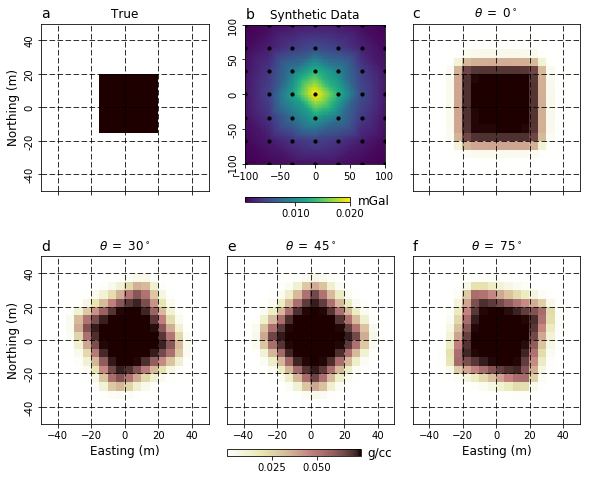

In [206]:
from scipy.interpolate import griddata
figName = 'Lp_26ptGrad.png'

# Mesh.TensorMesh.writeModelUBC(mesh,'Invmodel.sus',mrec_ROT)
xlim = [-50,50]
ylim = [-50,50]
zlim = [-110,0]
indz = -10
indy = 25
vmin, vmax = 0, 0.075

fig = plt.figure(figsize=(8.5,7))

ax1 = plt.subplot(2,3,2)

pos = ax1.get_position()
ax1.set_position([pos.x0+0.03, pos.y0+0.06, pos.width, pos.height])

plt.scatter(xyzLoc[:, 0], xyzLoc[:, 1], c='k', s=10)

# Create grid of points
x = np.linspace(xyzLoc[:, 0].min(), xyzLoc[:, 0].max(), 100)
y = np.linspace(xyzLoc[:, 1].min(), xyzLoc[:, 1].max(), 100)

X, Y = np.meshgrid(x, y)

# Interpolate
d_grid = griddata(xyzLoc[:, 0:2], data, (X, Y), method='linear')
im = plt.imshow(d_grid, extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower')
ax1.set_xlabel('', size=12)
ax1.set_ylabel('', size=12)
x = np.linspace(-100,100,5)
ax1.set_yticks(list(map(int, x)))
ax1.set_yticklabels(map(str, map(int, x)), rotation=90, va='center')
ax1.set_title('Synthetic Data')
ax1.set_title('b',loc='left', fontsize=14)

pos = ax1.get_position()
axbar = plt.axes([pos.x0, pos.y0-0.07,  pos.width*.75, pos.height*.75])
cbar = plt.colorbar(im, orientation='horizontal',format='%.3f')
cbar.set_ticks(np.linspace(0,0.02,3))
axbar.text(pos.x0+0.65, pos.y0-.9,'mGal', size=12)
axbar.axis('off')


# ax1.set_position([pos.x0, pos.y0, pos.width*1.25, pos.height*1.25])


axs = plt.subplot(2,3,1)
im = mesh.plotSlice(model, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
axs.set_aspect('equal')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
im[0].vmin=vmin
im[0].vmax=vmax
im[0].clim=([vmin,vmax])
axs.grid(True, color='k', linestyle='--')
axs.set_title('True')
x = np.linspace(-40,40,5)
axs.set_yticks(list(map(int, x)))
axs.set_yticklabels(map(str, map(int, x)), rotation=90, va='center')
axs.set_ylabel('Northing (m)', size=12)
pos = axs.get_position()
axs.set_xticklabels([])
axs.set_xlabel('')
axs.set_position([pos.x0-0.03, pos.y0, pos.width*1.2, pos.height*1.2])
axs.set_title('a',loc='left', fontsize=14)


axs = plt.subplot(2,3,3)
im = mesh.plotSlice(mrec90, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
axs.set_aspect('equal')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
im[0].vmin=vmin
im[0].vmax=vmax
im[0].clim=([vmin,vmax])
axs.grid(True, color='k', linestyle='--')
axs.set_title(r'$\theta\;=\;0^\circ$')
axs.set_yticklabels([])
axs.set_ylabel('')
pos = axs.get_position()
axs.set_xticklabels([])
axs.set_xlabel('')
axs.set_position([pos.x0+0.03, pos.y0, pos.width*1.2, pos.height*1.2])
axs.set_title('c',loc='left', fontsize=14)

axs = plt.subplot(2,3,4)
im = mesh.plotSlice(mrec30, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
axs.set_aspect('equal')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
im[0].vmin=vmin
im[0].vmax=vmax
im[0].clim=([vmin,vmax])
axs.grid(True, color='k', linestyle='--')
axs.set_title(r'$\theta\;=\;30^\circ$')
x = np.linspace(-40,40,5)
axs.set_yticks(list(map(int, x)))
axs.set_yticklabels(map(str, map(int, x)), rotation=90, va='center')
axs.set_xlabel('Easting (m)', size=12)
pos = axs.get_position()
axs.set_ylabel('Northing (m)', size=12)
axs.set_position([pos.x0-.03, pos.y0-0.05, pos.width*1.2, pos.height*1.2])
axs.set_title('d',loc='left', fontsize=14)

axs = plt.subplot(2,3,5)
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0-0.05, pos.width*1.2, pos.height*1.2])

im = mesh.plotSlice(mrec45, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
axs.set_aspect('equal')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
im[0].vmin=vmin
im[0].vmax=vmax
im[0].clim=([vmin,vmax])
axs.set_title(r'$\theta\;=\;45^\circ$',loc='center')
axs.set_yticklabels([])
axs.set_ylabel('')
axs.grid(True, color='k', linestyle='--')
axs.set_xlabel('', size=12)
axs.set_title('e',loc='left', fontsize=14)

pos = axs.get_position()
axbar = plt.axes([pos.x0, pos.y0-0.06,  pos.width*.8, pos.height*.8])
cbar = plt.colorbar(im[0], orientation='horizontal',format='%.3f')
cbar.set_ticks(np.linspace(vmin,vmax,4))
axbar.text(pos.x0+0.65, pos.y0-.35,'g/cc', size=12)
axbar.axis('off')


axs = plt.subplot(2,3,6)
im = mesh.plotSlice(mrec60, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
axs.set_aspect('equal')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
im[0].vmin=vmin
im[0].vmax=vmax
im[0].clim=([vmin,vmax])
axs.set_title(r'$\theta\;=\;75^\circ$')
axs.set_yticklabels([])
axs.set_ylabel('')
axs.grid(True, color='k', linestyle='--')
pos = axs.get_position()
axs.set_xlabel('Easting (m)', size=12)
axs.set_position([pos.x0+0.03, pos.y0-0.05, pos.width*1.2, pos.height*1.2])
axs.set_title('f',loc='left', fontsize=14)



           

plt.show()

fig.savefig(figName)

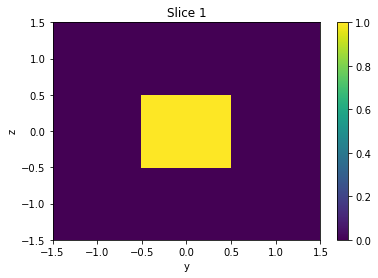

In [10]:
from ipywidgets import widgets


def GradSlicer(mesh, model):

    
    def plotIt(orientation,psi,theta,phi,vec,view):
    

    
        Gx = getDiffOpRot(mesh, np.deg2rad(psi), np.deg2rad(theta), np.deg2rad(phi), vec, forward=orientation)
        
        gradM = mkvc(Gx*model)

        ax = mesh.plotSlice(gradM, ind=1, normal=view)
        plt.colorbar(ax[0])
        plt.show()
        
    out = widgets.interactive(plotIt,                              
                              orientation = widgets.Dropdown(options={'Forward': True, 'Backward': False},value=True,description='Orientation:'),
                              psi = widgets.FloatSlider(min=-90, max=90, step=1,value=0, continuous_update=False),
                              theta = widgets.FloatSlider(min=-90, max=90, step=1,value=0, continuous_update=False),
                              phi = widgets.FloatSlider(min=-180, max=180, step=1,value=0, continuous_update=False),
                              vec = widgets.RadioButtons(options=['X', 'Y', 'Z'], value='X', description='Vector:',disabled=False),
                              view = widgets.RadioButtons(options=['X', 'Y', 'Z'], value='X', description='Normal:',disabled=False)
                             )

    return out

mesh = Mesh.TensorMesh([np.ones(3),np.ones(3),np.ones(3)], x0='CCC')
model = np.zeros((mesh.nC,1))
model[int(mesh.nC/2)] = 1

GradSlicer(mesh, model)

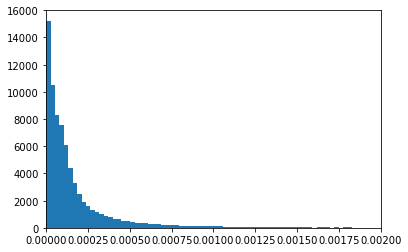

In [11]:
axs = plt.subplot()
plt.hist(np.abs(Dx1*IRLS.l2model),200)
# plt.hist(np.abs(Dx1*mrec),200)
axs.set_xlim(0,0.002)
plt.show()